# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

**Цель:** Построить модель для определения стоимости авомобилей.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Задачи:** Изучить данные, подготовить выборки, Обучить несколько моделей, проанализировать их и выбрать лучшую.

**Описание данных**: В датасете `autos.csv` 15 признаков и 1 целевой признак.

Признаки:

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

Целевой признак:

- `Price` — цена (евро)

**План работы:**
1. Загрузка данных
2. Предобработка данных
3. Подготовка данных для обучения
4. Обучение моделей
5. Анализ моделей

In [1]:
!pip install -q feature-engine

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler,
                                   MinMaxScaler)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from feature_engine.encoding import CountFrequencyEncoder
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from time import time
import warnings


warnings.filterwarnings('ignore')
RANDOM_STATE = 42

## Подготовка данных

### Загрузка данных

In [3]:
autos = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled','DateCreated'])

In [4]:
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [5]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

**Вывод:** В данных 354369 записей. Во многих столбцах присутствуют пропуски. Типы данных совпадают с действительными.

### Предобработка данных

#### Дубликаты

Проверим данные на наличие полных дублей и удалим их.

In [6]:
autos.duplicated().sum()

4

In [7]:
autos = autos.drop_duplicates()
autos.duplicated().sum()

0

#### Удаление столбцов

Столбцы `DateCrawled`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen` не влияют на цену автомобилей, эти столбцы можно удалить. Также удалим `RegistrationMonth`, так как он не содержит ценной информации, для предсказаний будет достаточно года регистрации.

In [8]:
del_col = ['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen','RegistrationMonth']
autos = autos.drop(del_col, axis=1)

autos.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Проверим наличие явных дубликатов после удаления признаков и удалим их.

In [9]:
autos.duplicated().sum()

45036

In [10]:
autos = autos.drop_duplicates()
autos.duplicated().sum()

0

#### Обработка пропусков

In [11]:
cat_cols = ['VehicleType','Gearbox', 'Model', 'FuelType','Brand','Repaired']
for col in cat_cols:
    print(col, sorted(autos[col].unique().astype(str)))

VehicleType ['bus', 'convertible', 'coupe', 'nan', 'other', 'sedan', 'small', 'suv', 'wagon']
Gearbox ['auto', 'manual', 'nan']
Model ['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 'doblo', 'ducato', 'duster', 'e_klasse', 'elefan

В столбце `VehicleType` заменим пропуски на `other`.

In [12]:
autos['VehicleType'] = autos['VehicleType'].fillna('other')
autos['VehicleType'].unique()

array(['other', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon'], dtype=object)

В столбце `Gearbox`  заменим пропуски на значение `unknown`

In [13]:
autos['Gearbox'] = autos['Gearbox'].fillna('unknown')
autos['Gearbox'].unique()

array(['manual', 'auto', 'unknown'], dtype=object)

Обработаем неявные дубли в столбце `FuelType` и заменим пропуски на `other`

In [14]:
autos['FuelType'] = autos['FuelType'].replace({'gasoline':'petrol','cng':'gas','lpg':'gas', np.nan:'other'})
autos['FuelType'].unique()

array(['petrol', 'other', 'gas', 'hybrid', 'electric'], dtype=object)

В столбце `Repaired` заменим пропуски на `no` на основе предположения, что если не указано, значит, ремонта не было.

In [15]:
autos['Repaired'] = autos['Repaired'].fillna('no')
autos['Repaired'].unique()

array(['no', 'yes'], dtype=object)

В столбце `Model` заметим пропуски и значение `other` на `unknown`.

In [16]:
autos['Model'] = autos['Model'].replace({'other':'unknown', np.nan:'unknown'})

#### Обработка аномалий в числовых признаках

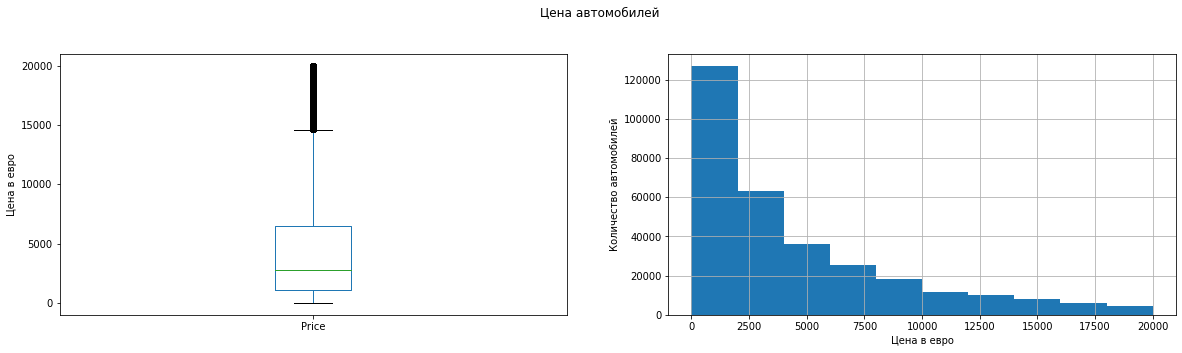

In [17]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)

autos['Price'].plot(kind='box',ax=axs[0])
axs[0].set_ylabel('Цена в евро')

autos['Price'].hist(bins=10,ax=axs[1])
axs[1].set_ylabel('Количество автомобилей')
axs[1].set_xlabel('Цена в евро')

fig.suptitle('Цена автомобилей')
plt.subplots_adjust(top= 0.85 )
plt.rc('font', size= 15 ) 
plt.show()

Удалим объявления, где цена меньше 700 евро.

In [18]:
autos = autos[autos['Price']>=700]

Исследуем признак `RegistrationYear`.

In [19]:
print(sorted(autos['RegistrationYear'].unique()))

[1000, 1001, 1039, 1234, 1400, 1500, 1600, 1800, 1910, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2290, 2500, 2800, 2900, 3000, 3200, 3700, 4000, 4100, 4500, 5000, 5300, 5555, 5911, 6000, 7000, 7100, 7800, 8500, 8888, 9000, 9999]


Удалим данные с аномально большим или мааленьким годом регистрации.

In [20]:
autos = autos[(autos['RegistrationYear']>1970)&(autos['RegistrationYear']<2016)]

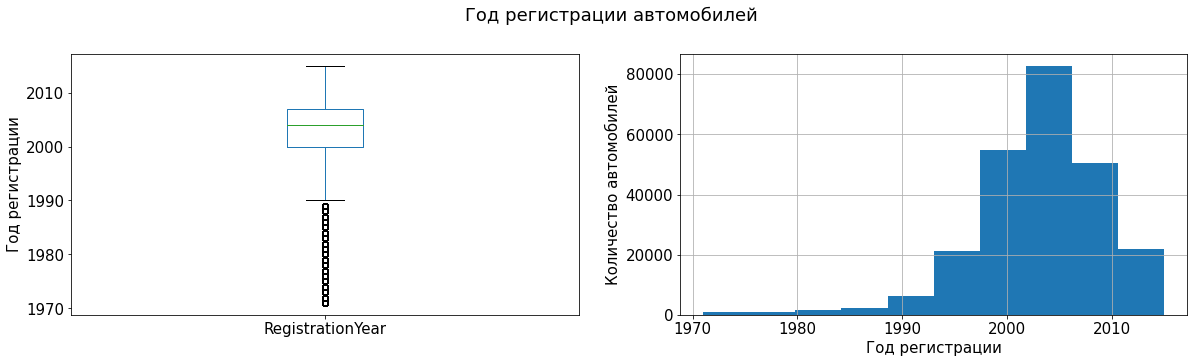

In [21]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)

autos['RegistrationYear'].plot(kind='box',ax=axs[0])
axs[0].set_ylabel('Год регистрации')

autos['RegistrationYear'].hist(bins=10,ax=axs[1])
axs[1].set_ylabel('Количество автомобилей')
axs[1].set_xlabel('Год регистрации')

fig.suptitle('Год регистрации автомобилей')
plt.subplots_adjust(top= 0.85 )
plt.rc('font', size= 15 ) 
plt.show()

Исследуем мощность автомобилей.

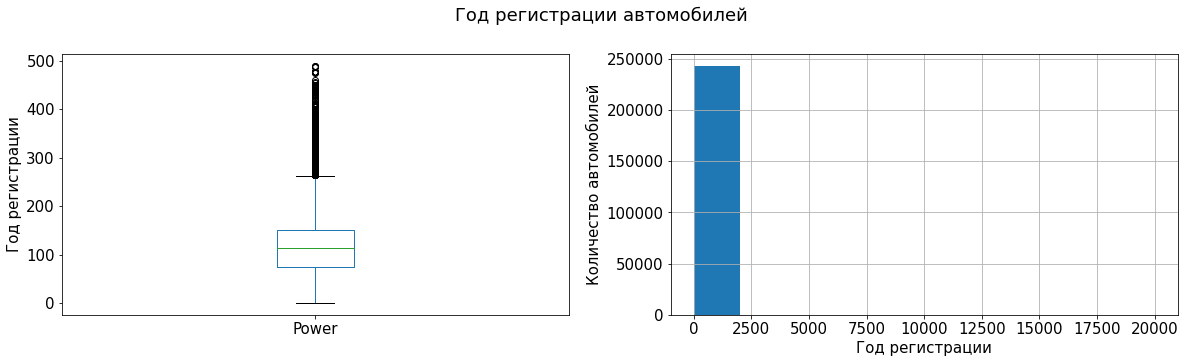

In [22]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)

autos[autos['Power']<500]['Power'].plot(kind='box',ax=axs[0])
axs[0].set_ylabel('Год регистрации')

autos['Power'].hist(bins=10,ax=axs[1])
axs[1].set_ylabel('Количество автомобилей')
axs[1].set_xlabel('Год регистрации')

fig.suptitle('Год регистрации автомобилей')
plt.subplots_adjust(top= 0.85 )
plt.rc('font', size= 15 ) 
plt.show()

Удалим аномальные значения мощности.

In [23]:
autos = autos.loc[(autos['Power']>30)&(autos['Power']<=500)]

Построим графики для признака `Kilometer`.

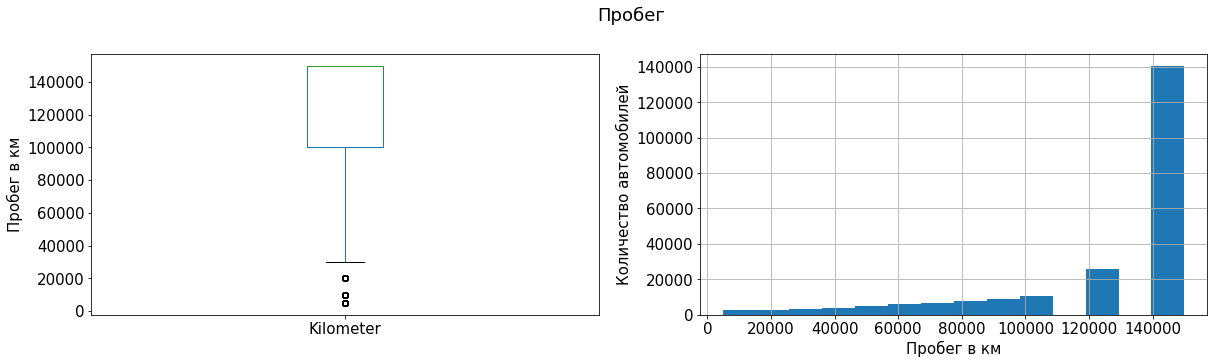

In [24]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)

autos['Kilometer'].plot(kind='box',ax=axs[0])
axs[0].set_ylabel('Пробег в км')

autos['Kilometer'].hist(bins=14,ax=axs[1])
axs[1].set_ylabel('Количество автомобилей')
axs[1].set_xlabel('Пробег в км')

fig.suptitle('Пробег')
plt.subplots_adjust(top= 0.85 )
plt.rc('font', size= 15 ) 
plt.show()

Аномалий в этом признаке нет.

#### Вывод

В ходе предобработки данных мы:
- Удалили полные дубликаты и неинформативные признаки
- Обработали пропуски в категориальных признаках, заменив их на заглушки : unknown или other
- В столбце `FuelType` исключили неявные дубли
- В `Repaired` пропуски заменили на значение no
- Оставили записи только с ценой автомобиля не меньше 700 евро
- Исключили аномально большие и маленькие года регистрации автомобилей
- В данных оставили машины, мощность которых от 30 до 500 л.с.


## Обучение моделей

### Подготовка данных

Закодируем и масштабируем данные.

In [25]:
ohe_col = ['VehicleType','Gearbox','FuelType','Repaired']
fre_col = ['Model', 'Brand']
ord_col = ['RegistrationYear','Kilometer']

In [26]:
num_col = ['Power']

autos = autos.reset_index(drop=True)
auto = autos.copy()

In [27]:
scaler = StandardScaler()
auto[num_col] = scaler.fit_transform(auto[num_col])

In [28]:
cf = CountFrequencyEncoder(encoding_method='frequency', missing_values='ignore')
auto[fre_col] = cf.fit_transform(auto[fre_col])

In [29]:
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)

In [30]:
auto[ord_col] = ordinal_encoder.fit_transform(auto[ord_col])

In [31]:
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
auto_ohe = ohe_encoder.fit_transform(auto[ohe_col])
names = ohe_encoder.get_feature_names_out() 

In [32]:
auto = auto.drop(ohe_col, axis=1)
df = pd.DataFrame(auto_ohe, columns=names)
auto = auto.join(df, how='left')
auto.head()

,Price,RegistrationYear,Power,Model,Kilometer,Brand,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,...,Gearbox_auto,Gearbox_manual,Gearbox_unknown,FuelType_electric,FuelType_gas,FuelType_hybrid,FuelType_other,FuelType_petrol,Repaired_no,Repaired_yes
0,18300,40.0,1.182193,0.106725,11.0,0.092178,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,9800,33.0,0.679871,0.002098,11.0,0.002340,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,1500,30.0,-0.957326,0.075779,12.0,0.204656,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,3600,37.0,-1.068953,0.007354,9.0,0.019070,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,2200,33.0,-0.324773,0.015196,12.0,0.031958,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


### Обучение моделей

Отделим целевой признак и разделим данные на обучающую и тестовую выборки.

In [33]:
X = auto.drop('Price', axis=1)
y = auto['Price']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42)

Создадим функцию для расчета RMSE.

In [35]:
def rmse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mse = ((y_true - y_pred)**2).mean()
    res = np.sqrt(mse)
    return res

RMSE = make_scorer(rmse, greater_is_better = False)

Далее подберем параметры и обучим модели линейной регрессии, дерева принятия решений с градиентным бустингом и без него. Посчитаем время затраченное на обучение модели и предсказание значений, а также метрику RMSE с помощью кросс-валидации для анализа точности полученных результатов

#### LinearRegression

In [36]:
start = time()

lr = LinearRegression(fit_intercept=False)
lr.fit(X_train, y_train)

end = time()
time_fit_lr = end - start
print('Время обучения:', time_fit_lr)

Время обучения: 0.27490234375


In [37]:
start = time()

y_pred_lr = lr.predict(X_train)

end = time()
time_pred_lr = end - start
print('Время предсказания:', time_pred_lr)

Время предсказания: 0.10126161575317383


In [38]:
model = LinearRegression(fit_intercept=False)
rmse_lr = round(-cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=4).mean(),1)
print('Значение RMSE линейной регрессии:', rmse_lr)

Значение RMSE линейной регрессии: 2902.5


#### DecisionTreeRegressor

In [39]:
model_tr = DecisionTreeRegressor(random_state=RANDOM_STATE)

In [40]:
param_tr = {'max_depth':[None] + [i for i in range(2, 7)] ,'min_samples_leaf':[3,4,5,6,7]}

In [41]:
grid_tr = GridSearchCV(model_tr,param_tr, cv=4, scoring = RMSE, n_jobs=-1)
grid_tr.fit(X_train, y_train)
best_params = grid_tr.best_params_
best_params

{'max_depth': None, 'min_samples_leaf': 7}

In [42]:
start = time()

tr = DecisionTreeRegressor(**best_params, random_state=RANDOM_STATE)
tr.fit(X_train, y_train)

end = time()
time_fit_tr = end - start
print('Время обучения:', time_fit_tr)

Время обучения: 0.7331995964050293


In [43]:
start = time()

y_pred_tr = tr.predict(X_train)

end = time()
time_pred_tr = end - start
print('Время предсказания:', time_pred_tr)

Время предсказания: 0.04746365547180176


In [44]:
rmse_tr = round(-grid_tr.best_score_,1)
print('Значение RMSE модели деревав решений:', rmse_tr)

Значение RMSE модели деревав решений: 1810.7


#### LightGBM

In [45]:
model_lgbm = LGBMRegressor(n_jobs=-1, random_state=RANDOM_STATE)
param_lgbm = {'num_leaves':[60, 70],'subsample_for_bin':[100000, 200000],'max_depth':[None, 5,7] }
grid_lgbm = GridSearchCV(model_lgbm,param_lgbm, cv=4, scoring = RMSE, n_jobs=-1)
grid_lgbm.fit(X_train, y_train)
best_params = grid_lgbm.best_params_
best_params

{'max_depth': None, 'num_leaves': 70, 'subsample_for_bin': 100000}

In [46]:
start = time()

lgbm = LGBMRegressor(**best_params, n_jobs=-1, random_state=RANDOM_STATE)
lgbm.fit(X_train, y_train)

end = time()
time_fit_lgbm = end - start
print('Время обучения:', time_fit_lgbm)

Время обучения: 7.000038146972656


In [47]:
start = time()

y_pred_lgbm = lgbm.predict(X_train)

end = time()
time_pred_lgbm = end - start
print('Время предсказания:', time_pred_lgbm)

Время предсказания: 1.6073760986328125


In [48]:
rmse_lgbm = round(-grid_lgbm.best_score_,1)
print('Значение RMSE модели дерева решений с градиентным бустингом:', rmse_lgbm)

Значение RMSE модели дерева решений с градиентным бустингом: 1647.4


## Анализ моделей

Составим таблицу из полученных данных и выберем лучшую модель.

In [49]:
data = np.array([[time_fit_lr, time_pred_lr, rmse_lr],
                 [time_fit_tr, time_pred_tr, rmse_tr],
                 [time_fit_lgbm, time_pred_lgbm, rmse_lgbm]])
df = pd.DataFrame(data=data,
                  columns=['Время обучения, с','Время предсказания, с','RMSE'])
df.index = ['LinearRegression','DecisiontreeRegressor','LightGBM']
df

,"Время обучения, с","Время предсказания, с",RMSE
LinearRegression,0.274902,0.101262,2902.5
DecisiontreeRegressor,0.733200,0.047464,1810.7
LightGBM,7.000038,1.607376,1647.4


In [50]:
y_pred = tr.predict(X_test)
rmse = round(mean_squared_error(y_test, y_pred, squared=False),1)
print('Значение RMSE модели дерева решений на тестовой выборке:', rmse)

Значение RMSE модели дерева решений на тестовой выборке: 1769.3


**Вывод:**

Линейная регрессия работает быстро, но в предсказаниях есть большие ошибки. RMSE моделей дерева решений почти одинакова, разницу в 150 евро можно считать незначительной. Однако модель без градиентного бустинга обучается во много раз быстрее. RMSE на тестовой выборке выбранной модели равно 1769.3.

## Общий вывод

Перед обучением моделей мы обработали данные:
- Удалили полные дубликаты и неинформативные признаки
- Обработали пропуски в категориальных признаках, заменив их на заглушки : unknown или other
- В столбце `FuelType` исключили неявные дубли
- В `Repaired` пропуски заменили на значение no
- Оставили записи только с ценой автомобиля не меньше 700 евро
- Исключили аномально большие и маленькие года регистрации автомобилей
- В данных оставили машины, мощность которых от 30 до 500 л.с.

Затем закодировали категориальные признаки с помощью кодировщиков OneHotEncoder, OrdinalEncoder и CountFrequencyEncoder. Для масштабирования числовых признаков использовали StandardScaler. 

Для того, чтобы получить лучший результат, обучали несколько моделей и подбирали для них параметры. Для сравнения качества использовали метрику RMSE на кросс-валидации.
- RMSE линейной регрессии с параметром `'fit_intercept': False` равна 2903
- RMSE дерева решений с параметрами `'max_depth': None, 'min_samples_leaf': 7` равна 1811
- RMSE дерева решений с градиентрым бустингом с параметрами `'max_depth': None, 'num_leaves': 70, 'subsample_for_bin': 100000` равна 1647

Проанализировав качество и время на обучение и предсказание моделей, мы выбрали модель DecisionTreeRegressor, так как она быстро и качественно работает. Ее RMSE на тестовой выборке равна 1769.3.